In [2]:
import random
import pandas as pd
import matplotlib.pyplot as plt
from jupyterthemes import jtplot

jtplot.style(theme="onedork")

In [3]:
url = "https://www.datenportal.bmbf.de/portal/docs/Tabelle-1.10.2.csv"

df_raw = pd.read_csv(url, delimiter=";", header=[4,5,6],skipfooter=17, engine='python', decimal=",", index_col=0)
df_raw = df_raw[[c for c in df_raw.columns if "%" not in c[2]]]
df_raw.columns = df_raw.columns.droplevel(2)
df_raw = df_raw.stack()
df_raw

Bevölkerung 2)  Bruttoinlandsprodukt (nominal)  \
Baden-Württemberg 1991          9904.0                           242.9   
                  2000         10359.2                           308.8   
                  2008         10506.2                           381.9   
                  2009         10491.0                           353.5   
                  2010         10480.4                           382.9   
...                                ...                             ...   
Thüringen         2016          2164.4                            59.0   
                  2017          2154.7                            61.1   
                  2018          2147.2                            62.1   
                  2019          2138.3                            63.3   
                  2020          2125.4                            61.5   

                        Erwerbstätige 3)  
Baden-Württemberg 1991            5174.5  
                  2000            5509.3  
                  2008            5752.5  
                  2009            5718.5  
                  2010            5720.1  
...                                  ...  
Thüringen         2016            1041.2  
                  2017            1045.1  
                  2018            1047.4  
                  2019            1044.7  
                  2020            1024.5  

[240 rows x 3 columns]

In [4]:
df = df_raw.loc[(slice(None),"2020"),:]
df.index = df.index.droplevel(1)
df

,Bevölkerung 2),Bruttoinlandsprodukt (nominal),Erwerbstätige 3)
Baden-Württemberg,11102.0,500.8,6311.4
Bayern,13123.6,610.2,7647.7
Berlin,3662.5,154.6,2058.6
Brandenburg,2524.8,73.9,1117.7
Bremen,679.5,31.6,432.6
Hamburg,1845.2,118.1,1285.4
Hessen,6288.7,281.4,3491.2
Mecklenburg-Vorpommern,1609.4,46.0,747.9
Niedersachsen,7996.0,295.9,4111.4
Nordrhein-Westfalen,17931.8,697.1,9550.2


In [5]:
def random_split(n_elements, group_names):
    if isinstance(group_names, int):
        group_names = set(range(group_names))
    assert len(group_names)<n_elements
    while True:
        split = random.choices(population=list(group_names), k=n_elements)
        if len(set(split))==len(group_names):
            return split


def single_changes(split):
    group_names = set(split)
    for ix,group_name in enumerate(split):
        for new_group_name in group_names - {group_name}:
            split[ix] = new_group_name
            if len(set(split)) == len(group_names):
                yield split.copy()
        split[ix] = group_name


def split_approx(df_features, group_names, metric):
    split = random_split(len(df_features), group_names)
    while True:
        new_splits = list(single_changes(split))
        new_metrics = [metric(new_split, df_features) for new_split in new_splits]
        if min(new_metrics)>=metric(split, df_features):
            return split
        split = new_splits[new_metrics.index(min(new_metrics))]

In [6]:
def calc_split_metric(split, df):
    df3 = df.groupby(split).sum()
    df3 /= df3.sum()
    return (df3.max() - df3.min()).sum()

In [7]:
pd.options.mode.chained_assignment = None

In [8]:
group_col = "group"
assert group_col not in df.columns
df.loc[:,group_col] = split_approx(df, 3, calc_split_metric)
df.groupby(group_col).sum()

,Bevölkerung 2),Bruttoinlandsprodukt (nominal),Erwerbstätige 3)
group,,,
0,27480.5,1167.4,15212.8
1,27392.1,1074.8,14555.5
2,28250.3,1089.9,15013.8


In [9]:
df = df.set_index(group_col, append=True)
df

,,Bevölkerung 2),Bruttoinlandsprodukt (nominal),Erwerbstätige 3)
,group,,,
Baden-Württemberg,2,11102.0,500.8,6311.4
Bayern,0,13123.6,610.2,7647.7
Berlin,2,3662.5,154.6,2058.6
Brandenburg,2,2524.8,73.9,1117.7
Bremen,2,679.5,31.6,432.6
Hamburg,0,1845.2,118.1,1285.4
Hessen,1,6288.7,281.4,3491.2
Mecklenburg-Vorpommern,0,1609.4,46.0,747.9
Niedersachsen,0,7996.0,295.9,4111.4


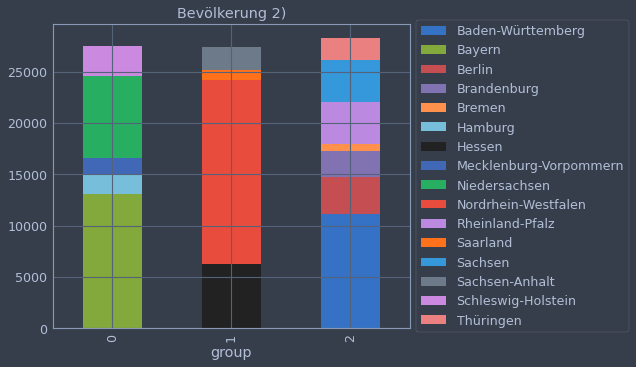

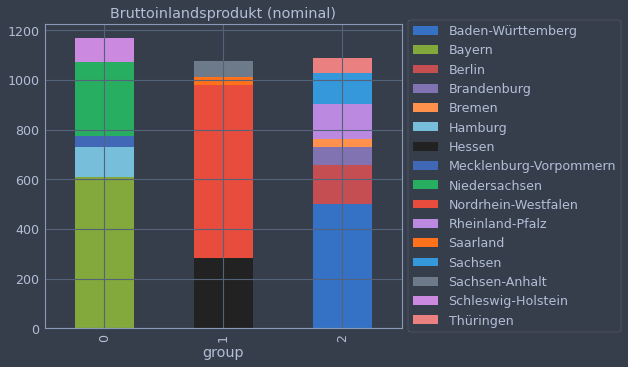

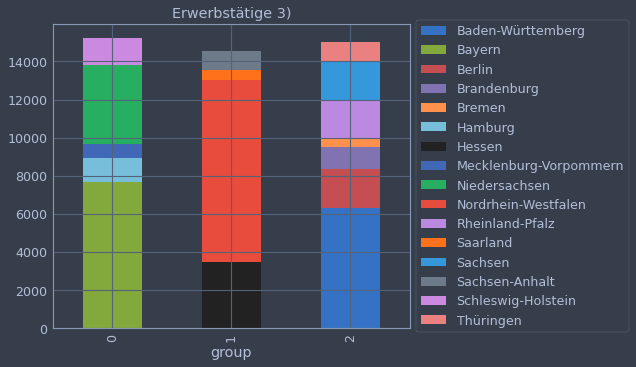

In [10]:
for col in df:
    df[col].unstack().T.plot.bar(stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
    plt.title(col)
    plt.show()